# 05 - Model Training & Evaluation

This notebook covers training and evaluating both traditional ML and transformer-based models for classifying public correspondence.

### 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

W0603 11:18:21.120000 76037 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


### Data Loading and Preparation

In [2]:
# Load feature-engineered data (adjust the path if needed)
df = pd.read_csv('../data/twcs/twcs_features.csv')
print('Shape:', df.shape)
df.head()

Shape: (1254662, 13)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,message_type,clean_text,clean_text_length,clean_text_word_count,clean_text_char_count,message_type_encoded
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,company_response,i understand i would like to assist you we wou...,110,22,89,0
1,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,company_response,please send us a private message so that we ca...,114,22,93,0
2,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0,company_response,can you please send us a private message so th...,94,18,77,0
3,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,customer_complaint_or_inquiry,is the worst customer service,29,5,25,1
4,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0,company_response,we understand your concerns and wed like for y...,120,24,97,0


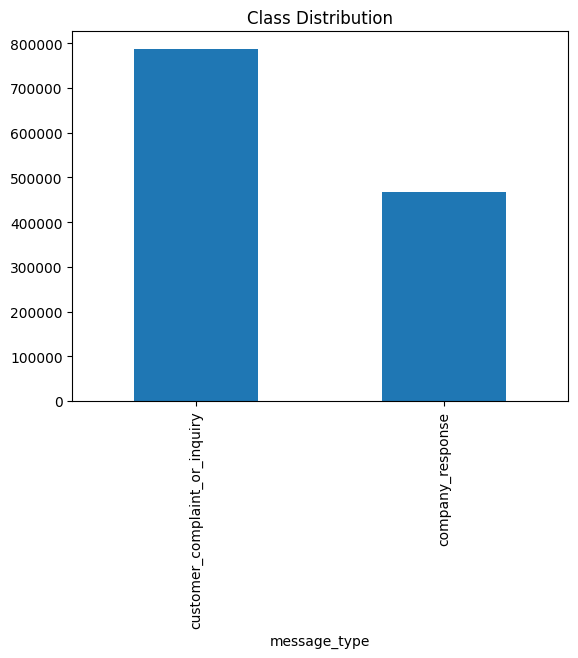

message_type
customer_complaint_or_inquiry    0.627536
company_response                 0.372464
Name: proportion, dtype: float64

In [3]:
# Check class balance (using the “message_type” column)
df['message_type'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()
df['message_type'].value_counts(normalize=True)

In [4]:
# Train/test split (using “clean_text” as X and “message_type_encoded” as y)
X = df['clean_text']
y = df['message_type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (1003729,) Test: (250933,)


### Feature Engineering for ML

In [5]:
# Ensure NaNs are dropped from both X and y
train_mask = ~X_train.isna()
test_mask = ~X_test.isna()

X_train_clean = X_train[train_mask]
X_test_clean = X_test[test_mask]
y_train_clean = y_train[train_mask]
y_test_clean = y_test[test_mask]

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)

# Add engineered features
engineered_features = ['clean_text_length', 'clean_text_word_count', 'clean_text_char_count']
X_train_eng = df.loc[X_train_clean.index, engineered_features].values
X_test_eng = df.loc[X_test_clean.index, engineered_features].values

# Combine TF-IDF and engineered features
from scipy.sparse import hstack
X_train_final = hstack([X_train_tfidf, X_train_eng])
X_test_final = hstack([X_test_tfidf, X_test_eng])

# Use the cleaned y
y_train = y_train_clean
y_test = y_test_clean

### Traditional ML Models

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ✅ Define optimized models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000, solver='saga', n_jobs=-1, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, n_jobs=-1, random_state=42
    ),
    'SVM (approx RBF)': make_pipeline(
        Nystroem(kernel='rbf', gamma=0.2, n_components=300, random_state=42),
        SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)
    )
}

results = {}

for name, model in models.items():
    try:
        print(f'\n🔄 Training: {name} ...')
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name] = {
            'accuracy': acc,
            'f1': f1,
            'model': model
        }

        print(f'✅ {name} – Accuracy: {acc:.3f}, F1 Score: {f1:.3f}')
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print('-' * 60)

    except Exception as e:
        print(f'❌ {name} failed to train: {e}')


🔄 Training: Logistic Regression ...
✅ Logistic Regression – Accuracy: 0.949, F1 Score: 0.949
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     93379
           1       0.95      0.97      0.96    156710

    accuracy                           0.95    250089
   macro avg       0.95      0.94      0.94    250089
weighted avg       0.95      0.95      0.95    250089

[[ 85162   8217]
 [  4564 152146]]
------------------------------------------------------------

🔄 Training: Random Forest ...
✅ Random Forest – Accuracy: 0.958, F1 Score: 0.958
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     93379
           1       0.96      0.98      0.97    156710

    accuracy                           0.96    250089
   macro avg       0.96      0.95      0.95    250089
weighted avg       0.96      0.96      0.96    250089

[[ 86463   6916]
 [  3583 153127]]
---------------------------------------

In [9]:
import joblib
from pathlib import Path

# Get the project root (assumes notebook is inside a subfolder like 'notebooks/')
notebook_dir = Path.cwd()
project_root = notebook_dir.parent  # Adjust this if you're deeper inside the project
models_dir = project_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save each model
for name, result in results.items():
    filename = f"{name.replace(' ', '_').replace('(', '').replace(')', '').lower()}_model.joblib"
    model_path = models_dir / filename
    joblib.dump(result['model'], model_path)
    print(f"💾 Saved {name} to {model_path}")

💾 Saved Logistic Regression to /Users/joy/Git/nlp-public-correspondence/models/logistic_regression_model.joblib
💾 Saved Random Forest to /Users/joy/Git/nlp-public-correspondence/models/random_forest_model.joblib
💾 Saved SVM (approx RBF) to /Users/joy/Git/nlp-public-correspondence/models/svm_approx_rbf_model.joblib


### BERT Model (Transformers)

In [11]:
    import torch
    print(torch.backends.mps.is_available())
    # Should print True if MPS is available

True


In [12]:
    import torch
    device = "mps"  # Or "cuda" if you are using CUDA (not applicable for M3 Max)
    if torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    tensor = torch.ones(2, 3, device=device)
    print(tensor)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='mps:0')


Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 62516/62516 [4:18:12<00:00,  4.04it/s, loss=0.000259]


BERT – Accuracy: 0.992, F1: 0.992
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     93379
           1       0.99      0.99      0.99    156710

    accuracy                           0.99    250089
   macro avg       0.99      0.99      0.99    250089
weighted avg       0.99      0.99      0.99    250089

[[ 92194   1185]
 [   936 155774]]


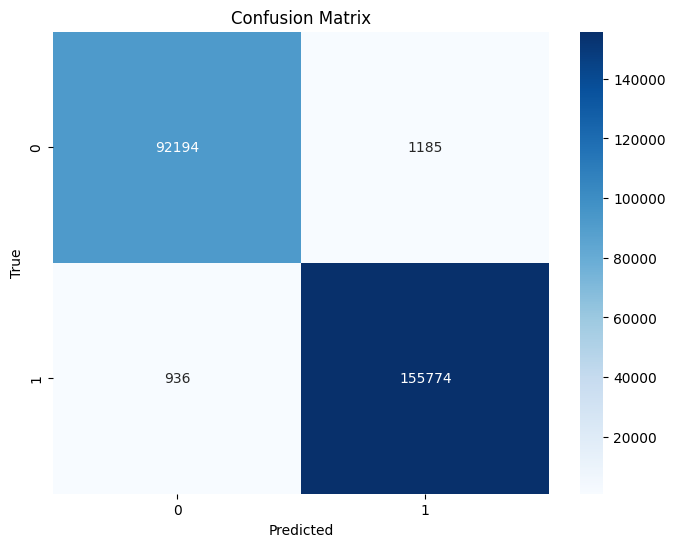

In [13]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Label Encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = y.unique()
label2id = {str(label): i for i, label in enumerate(labels)}
id2label = {i: str(label) for i, label in enumerate(labels)}

# 2. Tokenization Function
def encode_batch(texts, tokenizer, max_length=128):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# 3. Dataset Class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = encode_batch(texts, tokenizer, max_length)
        self.labels = torch.tensor(labels.values)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

# 4. Prepare Datasets
train_dataset = TweetDataset(X_train_clean, y_train_clean, tokenizer)
test_dataset = TweetDataset(X_test_clean, y_test_clean, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Device Setup (MPS on MacBook M3)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 6. Model Setup
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# 7. Training Loop
model.train()
for epoch in range(2):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

# 8. Evaluation Loop
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 9. Metrics and Plot
bert_acc = accuracy_score(all_labels, all_preds)
bert_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"BERT – Accuracy: {bert_acc:.3f}, F1: {bert_f1:.3f}")
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Append BERT’s performance to results

In [14]:
results["BERT"] = {
    "accuracy": bert_acc,
    "f1": bert_f1,
    "model": model  # The trained BERT model from the PyTorch loop
}

# Plot and export the comparison

<Figure size 1000x500 with 0 Axes>

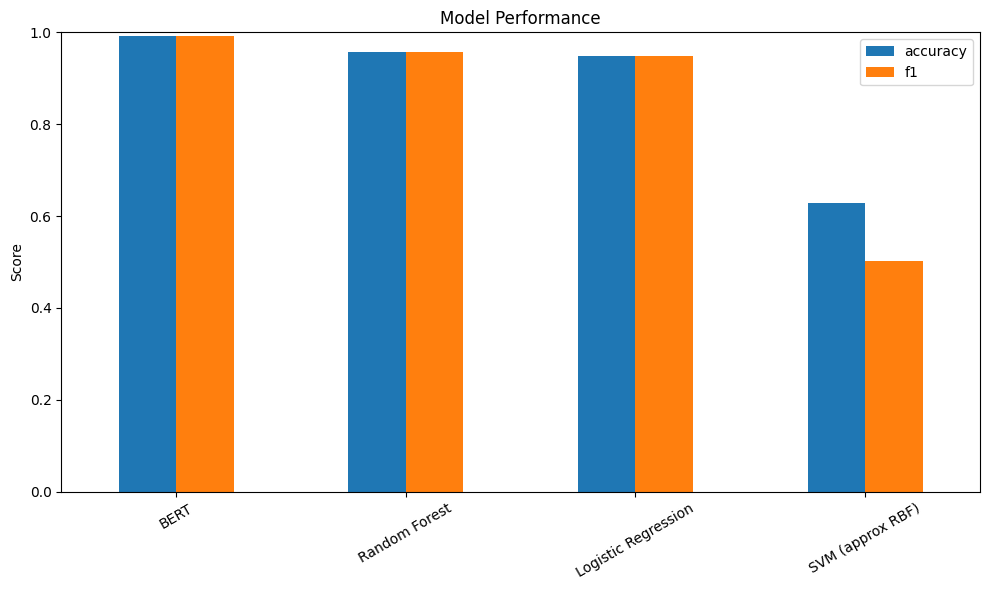

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Build a DataFrame from results
results_df = pd.DataFrame(results).T[['accuracy', 'f1']].sort_values(by='f1', ascending=False)

# Plot and export
plt.figure(figsize=(10, 5))
results_df.plot(kind='bar', rot=30, ylim=(0, 1), title='Model Performance', figsize=(10, 6))
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('../outputs/model_comparison.png', dpi=300)
plt.show()

# Export results as CSV

In [16]:
results_df.to_csv("../outputs/model_scores.csv")

# Save traditional models

In [17]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

for name, res in results.items():
    if name != "BERT":
        model_file = f"../models/{name.replace(' ', '_').lower()}_model.joblib"
        joblib.dump(res["model"], model_file)

# Save BERT model & tokenizer

In [19]:
model.save_pretrained("../models/bert_model")
tokenizer.save_pretrained("../models/bert_model")

('../models/bert_model/tokenizer_config.json',
 '../models/bert_model/special_tokens_map.json',
 '../models/bert_model/vocab.txt',
 '../models/bert_model/added_tokens.json')

# Display ranking summary

In [20]:
print("🔍 Model Ranking by F1 Score:\n")
print(results_df.sort_values("f1", ascending=False))

🔍 Model Ranking by F1 Score:

                     accuracy        f1
BERT                 0.991519  0.991517
Random Forest        0.958019  0.957858
Logistic Regression  0.948894  0.948679
SVM (approx RBF)     0.628136  0.501652
